In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


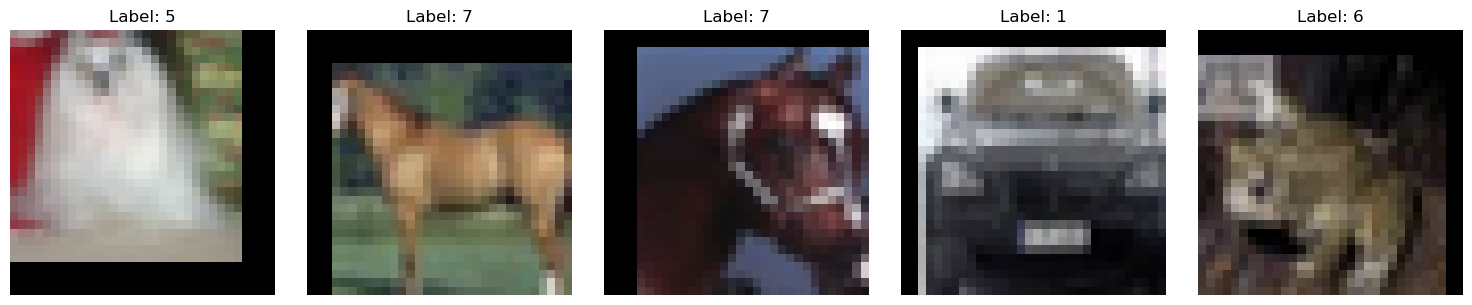

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:50<00:00,  6.91it/s]


Epoch 1 => Train Loss: 2.1166, Acc: 0.2286 | Val Loss: 1.8947, Acc: 0.2958


Epoch 2/100: 100%|██████████| 352/352 [00:49<00:00,  7.07it/s]


Epoch 2 => Train Loss: 1.8186, Acc: 0.3294 | Val Loss: 1.7492, Acc: 0.3408


Epoch 3/100: 100%|██████████| 352/352 [00:49<00:00,  7.09it/s]


Epoch 3 => Train Loss: 1.6861, Acc: 0.3762 | Val Loss: 1.6067, Acc: 0.3992


Epoch 4/100: 100%|██████████| 352/352 [00:49<00:00,  7.09it/s]


Epoch 4 => Train Loss: 1.5992, Acc: 0.4086 | Val Loss: 1.5406, Acc: 0.4232


Epoch 5/100: 100%|██████████| 352/352 [00:49<00:00,  7.08it/s]


Epoch 5 => Train Loss: 1.5284, Acc: 0.4390 | Val Loss: 1.4687, Acc: 0.4532


Epoch 6/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 6 => Train Loss: 1.4618, Acc: 0.4651 | Val Loss: 1.4049, Acc: 0.4744


Epoch 7/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 7 => Train Loss: 1.4008, Acc: 0.4922 | Val Loss: 1.6601, Acc: 0.4442


Epoch 8/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 8 => Train Loss: 1.3444, Acc: 0.5153 | Val Loss: 1.3168, Acc: 0.5258


Epoch 9/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 9 => Train Loss: 1.2983, Acc: 0.5314 | Val Loss: 1.3067, Acc: 0.5214


Epoch 10/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 10 => Train Loss: 1.2564, Acc: 0.5470 | Val Loss: 1.7932, Acc: 0.4492


Epoch 11/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 11 => Train Loss: 1.2169, Acc: 0.5644 | Val Loss: 1.2422, Acc: 0.5528


Epoch 12/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 12 => Train Loss: 1.1844, Acc: 0.5721 | Val Loss: 1.1572, Acc: 0.5758


Epoch 13/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 13 => Train Loss: 1.1487, Acc: 0.5884 | Val Loss: 1.1379, Acc: 0.5912


Epoch 14/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 14 => Train Loss: 1.1185, Acc: 0.6005 | Val Loss: 1.2822, Acc: 0.5546


Epoch 15/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 15 => Train Loss: 1.0906, Acc: 0.6096 | Val Loss: 1.0761, Acc: 0.6122


Epoch 16/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 16 => Train Loss: 1.0649, Acc: 0.6188 | Val Loss: 1.0919, Acc: 0.6036


Epoch 17/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 17 => Train Loss: 1.0400, Acc: 0.6294 | Val Loss: 1.1359, Acc: 0.5934


Epoch 18/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 18 => Train Loss: 1.0170, Acc: 0.6363 | Val Loss: 1.0749, Acc: 0.6218


Epoch 19/100: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s]


Epoch 19 => Train Loss: 0.9965, Acc: 0.6461 | Val Loss: 1.0657, Acc: 0.6134


Epoch 20/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 20 => Train Loss: 0.9771, Acc: 0.6518 | Val Loss: 1.1143, Acc: 0.6030


Epoch 21/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 21 => Train Loss: 0.9576, Acc: 0.6591 | Val Loss: 0.9927, Acc: 0.6446


Epoch 22/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 22 => Train Loss: 0.9410, Acc: 0.6663 | Val Loss: 0.9705, Acc: 0.6534


Epoch 23/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 23 => Train Loss: 0.9239, Acc: 0.6719 | Val Loss: 1.0179, Acc: 0.6362


Epoch 24/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 24 => Train Loss: 0.9042, Acc: 0.6792 | Val Loss: 0.9436, Acc: 0.6586


Epoch 25/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 25 => Train Loss: 0.8901, Acc: 0.6854 | Val Loss: 0.9397, Acc: 0.6694


Epoch 26/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 26 => Train Loss: 0.8725, Acc: 0.6922 | Val Loss: 0.9874, Acc: 0.6524


Epoch 27/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 27 => Train Loss: 0.8580, Acc: 0.6965 | Val Loss: 1.0896, Acc: 0.6260


Epoch 28/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 28 => Train Loss: 0.8480, Acc: 0.7002 | Val Loss: 0.8849, Acc: 0.6884


Epoch 29/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 29 => Train Loss: 0.8328, Acc: 0.7074 | Val Loss: 0.9233, Acc: 0.6784


Epoch 30/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 30 => Train Loss: 0.8233, Acc: 0.7090 | Val Loss: 0.8293, Acc: 0.7024


Epoch 31/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 31 => Train Loss: 0.8065, Acc: 0.7180 | Val Loss: 0.9687, Acc: 0.6654


Epoch 32/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 32 => Train Loss: 0.7902, Acc: 0.7225 | Val Loss: 0.8606, Acc: 0.6972


Epoch 33/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 33 => Train Loss: 0.7810, Acc: 0.7232 | Val Loss: 0.8930, Acc: 0.6916


Epoch 34/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 34 => Train Loss: 0.7693, Acc: 0.7285 | Val Loss: 0.9034, Acc: 0.6848


Epoch 35/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 35 => Train Loss: 0.7589, Acc: 0.7330 | Val Loss: 0.9134, Acc: 0.6914


Epoch 36/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 36 => Train Loss: 0.7481, Acc: 0.7366 | Val Loss: 0.9109, Acc: 0.6780


Epoch 37/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 37 => Train Loss: 0.7400, Acc: 0.7414 | Val Loss: 0.7951, Acc: 0.7152


Epoch 38/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 38 => Train Loss: 0.7248, Acc: 0.7450 | Val Loss: 0.8211, Acc: 0.7186


Epoch 39/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 39 => Train Loss: 0.7121, Acc: 0.7489 | Val Loss: 0.8872, Acc: 0.6950


Epoch 40/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 40 => Train Loss: 0.7084, Acc: 0.7522 | Val Loss: 0.8548, Acc: 0.6984


Epoch 41/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 41 => Train Loss: 0.6937, Acc: 0.7578 | Val Loss: 0.7860, Acc: 0.7216


Epoch 42/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 42 => Train Loss: 0.6845, Acc: 0.7611 | Val Loss: 0.7844, Acc: 0.7338


Epoch 43/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 43 => Train Loss: 0.6773, Acc: 0.7637 | Val Loss: 0.7727, Acc: 0.7338


Epoch 44/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 44 => Train Loss: 0.6650, Acc: 0.7699 | Val Loss: 0.7633, Acc: 0.7336


Epoch 45/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 45 => Train Loss: 0.6568, Acc: 0.7715 | Val Loss: 0.8885, Acc: 0.7014


Epoch 46/100: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s]


Epoch 46 => Train Loss: 0.6470, Acc: 0.7731 | Val Loss: 0.8021, Acc: 0.7176


Epoch 47/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 47 => Train Loss: 0.6384, Acc: 0.7773 | Val Loss: 0.7383, Acc: 0.7472


Epoch 48/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 48 => Train Loss: 0.6289, Acc: 0.7809 | Val Loss: 0.7032, Acc: 0.7540


Epoch 49/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 49 => Train Loss: 0.6228, Acc: 0.7818 | Val Loss: 0.7261, Acc: 0.7470


Epoch 50/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 50 => Train Loss: 0.6115, Acc: 0.7870 | Val Loss: 0.7634, Acc: 0.7342


Epoch 51/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 51 => Train Loss: 0.6027, Acc: 0.7900 | Val Loss: 0.7201, Acc: 0.7574


Epoch 52/100: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s]


Epoch 52 => Train Loss: 0.5938, Acc: 0.7927 | Val Loss: 0.6453, Acc: 0.7766


Epoch 53/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 53 => Train Loss: 0.5861, Acc: 0.7973 | Val Loss: 0.8215, Acc: 0.7200


Epoch 54/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 54 => Train Loss: 0.5785, Acc: 0.7999 | Val Loss: 0.7375, Acc: 0.7518


Epoch 55/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 55 => Train Loss: 0.5693, Acc: 0.8027 | Val Loss: 0.7092, Acc: 0.7574


Epoch 56/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 56 => Train Loss: 0.5646, Acc: 0.8039 | Val Loss: 0.7456, Acc: 0.7518


Epoch 57/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 57 => Train Loss: 0.5568, Acc: 0.8075 | Val Loss: 0.6619, Acc: 0.7716


Epoch 58/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 58 => Train Loss: 0.5490, Acc: 0.8082 | Val Loss: 0.6266, Acc: 0.7796


Epoch 59/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 59 => Train Loss: 0.5415, Acc: 0.8109 | Val Loss: 0.7052, Acc: 0.7650


Epoch 60/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 60 => Train Loss: 0.5322, Acc: 0.8157 | Val Loss: 0.6320, Acc: 0.7798


Epoch 61/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 61 => Train Loss: 0.5253, Acc: 0.8172 | Val Loss: 0.7087, Acc: 0.7624


Epoch 62/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 62 => Train Loss: 0.5198, Acc: 0.8196 | Val Loss: 0.7003, Acc: 0.7654


Epoch 63/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 63 => Train Loss: 0.5146, Acc: 0.8217 | Val Loss: 0.6256, Acc: 0.7906


Epoch 64/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 64 => Train Loss: 0.5054, Acc: 0.8254 | Val Loss: 0.6331, Acc: 0.7856


Epoch 65/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 65 => Train Loss: 0.5025, Acc: 0.8251 | Val Loss: 0.6227, Acc: 0.7886


Epoch 66/100: 100%|██████████| 352/352 [00:49<00:00,  7.18it/s]


Epoch 66 => Train Loss: 0.4948, Acc: 0.8271 | Val Loss: 0.6547, Acc: 0.7780


Epoch 67/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 67 => Train Loss: 0.4881, Acc: 0.8323 | Val Loss: 0.6327, Acc: 0.7864


Epoch 68/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 68 => Train Loss: 0.4838, Acc: 0.8321 | Val Loss: 0.5825, Acc: 0.7972


Epoch 69/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 69 => Train Loss: 0.4767, Acc: 0.8357 | Val Loss: 0.6675, Acc: 0.7824


Epoch 70/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 70 => Train Loss: 0.4692, Acc: 0.8361 | Val Loss: 0.6218, Acc: 0.7902


Epoch 71/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 71 => Train Loss: 0.4667, Acc: 0.8396 | Val Loss: 0.6895, Acc: 0.7788


Epoch 72/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 72 => Train Loss: 0.4645, Acc: 0.8408 | Val Loss: 0.5830, Acc: 0.8040


Epoch 73/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 73 => Train Loss: 0.4566, Acc: 0.8425 | Val Loss: 0.5745, Acc: 0.8032


Epoch 74/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 74 => Train Loss: 0.4527, Acc: 0.8435 | Val Loss: 0.6639, Acc: 0.7776


Epoch 75/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 75 => Train Loss: 0.4472, Acc: 0.8463 | Val Loss: 0.6073, Acc: 0.8008


Epoch 76/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 76 => Train Loss: 0.4404, Acc: 0.8488 | Val Loss: 0.5855, Acc: 0.8066


Epoch 77/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 77 => Train Loss: 0.4378, Acc: 0.8486 | Val Loss: 0.5979, Acc: 0.7988


Epoch 78/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 78 => Train Loss: 0.4325, Acc: 0.8508 | Val Loss: 0.6201, Acc: 0.8018


Epoch 79/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 79 => Train Loss: 0.4246, Acc: 0.8526 | Val Loss: 0.5570, Acc: 0.8158


Epoch 80/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 80 => Train Loss: 0.4221, Acc: 0.8535 | Val Loss: 0.6976, Acc: 0.7720


Epoch 81/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 81 => Train Loss: 0.4170, Acc: 0.8558 | Val Loss: 0.5847, Acc: 0.8078


Epoch 82/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 82 => Train Loss: 0.4101, Acc: 0.8585 | Val Loss: 0.6035, Acc: 0.8028


Epoch 83/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 83 => Train Loss: 0.4061, Acc: 0.8594 | Val Loss: 0.6752, Acc: 0.7818


Epoch 84/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 84 => Train Loss: 0.4036, Acc: 0.8623 | Val Loss: 0.5486, Acc: 0.8174


Epoch 85/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 85 => Train Loss: 0.3991, Acc: 0.8638 | Val Loss: 0.5983, Acc: 0.8016


Epoch 86/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 86 => Train Loss: 0.3925, Acc: 0.8650 | Val Loss: 0.6125, Acc: 0.8004


Epoch 87/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 87 => Train Loss: 0.3916, Acc: 0.8662 | Val Loss: 0.5670, Acc: 0.8134


Epoch 88/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 88 => Train Loss: 0.3853, Acc: 0.8686 | Val Loss: 0.5701, Acc: 0.8150


Epoch 89/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 89 => Train Loss: 0.3777, Acc: 0.8702 | Val Loss: 0.7656, Acc: 0.7776


Epoch 90/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 90 => Train Loss: 0.3781, Acc: 0.8703 | Val Loss: 0.5868, Acc: 0.8116


Epoch 91/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 91 => Train Loss: 0.3740, Acc: 0.8726 | Val Loss: 0.5706, Acc: 0.8072


Epoch 92/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 92 => Train Loss: 0.3713, Acc: 0.8720 | Val Loss: 0.6170, Acc: 0.8050


Epoch 93/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 93 => Train Loss: 0.3640, Acc: 0.8748 | Val Loss: 0.5473, Acc: 0.8230


Epoch 94/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 94 => Train Loss: 0.3608, Acc: 0.8756 | Val Loss: 0.6598, Acc: 0.7986


Epoch 95/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 95 => Train Loss: 0.3570, Acc: 0.8769 | Val Loss: 0.5591, Acc: 0.8166


Epoch 96/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 96 => Train Loss: 0.3619, Acc: 0.8744 | Val Loss: 0.6460, Acc: 0.8038


Epoch 97/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 97 => Train Loss: 0.3505, Acc: 0.8807 | Val Loss: 0.5525, Acc: 0.8184


Epoch 98/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 98 => Train Loss: 0.3490, Acc: 0.8793 | Val Loss: 0.5445, Acc: 0.8236


Epoch 99/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 99 => Train Loss: 0.3443, Acc: 0.8825 | Val Loss: 0.5557, Acc: 0.8286


Epoch 100/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 100 => Train Loss: 0.3407, Acc: 0.8834 | Val Loss: 0.5949, Acc: 0.8096


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("SGD_no_weightdecay.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

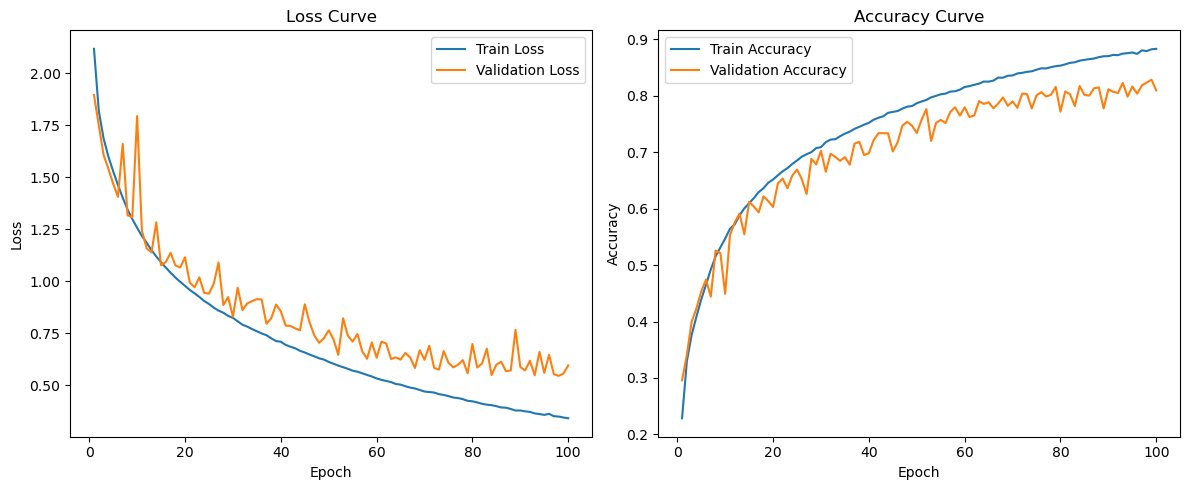

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [16]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 80.29%


In [19]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model_sgd.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 81.28%
